In [1]:
import math
import os

from ripser import ripser
from tqdm import tqdm

import matplotlib.pyplot as plt
import gtda.time_series
import numpy as np
import scipy.stats
import cripser
import persim
import wandb
import mne

import dataset
import utils

import plotly
import plotly.graph_objs as go

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
runs = {
    "Random Prediction": "gck92bcu",
    "Non-TDA Features": "x9tno3xy",
    "HEPC Features ($H_0$ Only)": "cet00lrx",
    "FAPC Features ($H_0$ Only)": "5uafqw62",
    "HEPC Features ($H_0 + H_1$)": "qbbn3vol",
    "FAPC Features ($H_0 + H_1$)": "4zumfrsp",
    "Non-TDA + HEPC Features ($H_0$ Only)": "6081bbli",
    "Non-TDA + FAPC Features ($H_0$ Only)": "e6tp1lga",
    "Non-TDA + HEPC Features ($H_0 + H_1$)": "3pay4ilf",
    "Non-TDA + FAPC Features ($H_0 + H_1$)": "b4azz6vb",
}
api = wandb.Api()

In [3]:
# Accuracy Table for XGBoost Model
data = {}
for run_name, run_id in runs.items():
    run_data = api.run(f"shashankmanjunath/tda_airflow_sleep_staging/{run_id}")
    run_history = run_data.history()
    data[run_name] = run_history

    train_ba = np.mean(run_history["train_ba"].tolist())
    test_ba = np.mean(run_history["test_ba"].tolist())
    cohen_kappa = np.mean(run_history["cohen_kappa"].tolist())

    test_cmat_arr = np.stack(run_history["test_cmat"].tolist())
    class_acc = np.stack([np.diag(x)/x.sum(1) for x in test_cmat_arr])
    class_acc = class_acc.mean(0)

    print(f"{run_name} & {train_ba:.3f} & {test_ba:.3f} & {cohen_kappa:.3f} & {class_acc[0]:.3f} & {class_acc[1]:.3f} & {class_acc[2]:.3f} \\\\")
    print("\hline")

<>:17: SyntaxWarning: invalid escape sequence '\h'
<>:17: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_29184/441819016.py:17: SyntaxWarning: invalid escape sequence '\h'
  print("\hline")


Random Prediction & 0.377 & 0.334 & 0.001 & 0.357 & 0.317 & 0.327 \\
\hline
Non-TDA Features & 0.568 & 0.555 & 0.222 & 0.604 & 0.591 & 0.471 \\
\hline
HEPC Features ($H_0$ Only) & 0.538 & 0.522 & 0.161 & 0.662 & 0.541 & 0.362 \\
\hline
FAPC Features ($H_0$ Only) & 0.626 & 0.616 & 0.289 & 0.681 & 0.616 & 0.550 \\
\hline
HEPC Features ($H_0 + H_1$) & 0.590 & 0.576 & 0.225 & 0.645 & 0.557 & 0.528 \\
\hline
FAPC Features ($H_0 + H_1$) & 0.635 & 0.625 & 0.303 & 0.686 & 0.629 & 0.560 \\
\hline
Non-TDA + HEPC Features ($H_0$ Only) & 0.621 & 0.605 & 0.271 & 0.669 & 0.633 & 0.513 \\
\hline
Non-TDA + FAPC Features ($H_0$ Only) & 0.648 & 0.633 & 0.309 & 0.683 & 0.633 & 0.584 \\
\hline
Non-TDA + HEPC Features ($H_0 + H_1$) & 0.634 & 0.619 & 0.292 & 0.668 & 0.645 & 0.545 \\
\hline
Non-TDA + FAPC Features ($H_0 + H_1$) & 0.655 & 0.641 & 0.322 & 0.691 & 0.645 & 0.588 \\
\hline


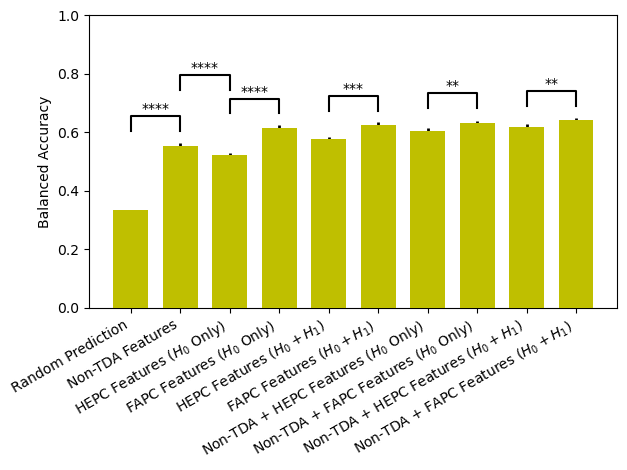

In [4]:
pairs = [
    ["Random Prediction", "Non-TDA Features"],
    ["HEPC Features ($H_0$ Only)", "FAPC Features ($H_0$ Only)"],
    ["HEPC Features ($H_0 + H_1$)", "FAPC Features ($H_0 + H_1$)"],
    ["Non-TDA + HEPC Features ($H_0$ Only)", "Non-TDA + FAPC Features ($H_0$ Only)"],
    ["Non-TDA + HEPC Features ($H_0 + H_1$)", "Non-TDA + FAPC Features ($H_0 + H_1$)"],
]

bar_kwargs = {'width': 0.7,'color':'y','linewidth':2,'zorder':5}
err_kwargs = {'zorder':0,'fmt': "none",'linewidth':2,'ecolor':'k'}

ind = []
chart_data = []
errs = []
cohen_kappa = []
for k, v in data.items():
    ind.append(k)
    chart_data.append(data[k]["test_ba"].tolist())
    cohen_kappa.append(data[k]["cohen_kappa"].tolist())
                 
fig, ax = plt.subplots()
ax.p1 = plt.bar(ind, [np.mean(x) for x in chart_data], **bar_kwargs)
ax.errs = plt.errorbar(ind, [np.mean(x) for x in chart_data], yerr=[np.std(x) for x in chart_data], **err_kwargs)
plt.xticks(rotation=30, ha="right")
plt.ylim([0, 1])

def barplot_annotate_brackets(num1, num2, data, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    center = np.arange(len(data))
    height = [np.mean(x) for x in data]
    res = scipy.stats.ttest_rel(data[num1], data[num2], alternative="two-sided")
    # vres = scipy.stats.mannwhitneyu(data[num1], data[num2], alternative="two-sided")
    pvalue = res.pvalue
    
    # * is p < 0.05
    # ** is p < 0.005
    # *** is p < 0.0005
    # etc.
    text = ''
    p = .05
    while pvalue < p:
        text += '*'
        p /= 10.
        if maxasterix and len(text) == maxasterix:
            break
    if len(text) == 0:
        text = 'n. s.'

    # text = f"{pvalue:.5f}"

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)

    plt.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs
    plt.text(*mid, text, **kwargs)

barplot_annotate_brackets(0, 1, chart_data, maxasterix=4)
barplot_annotate_brackets(1, 2, chart_data, maxasterix=4, dh=0.19)
barplot_annotate_brackets(2, 3, chart_data, maxasterix=4)
barplot_annotate_brackets(4, 5, chart_data, maxasterix=4)
barplot_annotate_brackets(6, 7, chart_data, maxasterix=4)
barplot_annotate_brackets(8, 9, chart_data, maxasterix=4)

plt.ylabel("Balanced Accuracy")
plt.tight_layout()
plt.savefig("results_significance.png", dpi=300)
plt.show()

In [5]:
# Image of PC approximation
idx = 25
data_dir = "/work/thesathlab/nchsdb/"

pt_ids = []
for pt_file in os.listdir(os.path.join(data_dir, "sleep_data")):
    if pt_file.endswith(".edf"):
        pt_ids.append(pt_file.replace(".edf", ""))

pt_id = pt_ids[idx]
print(pt_id)
save_dir = "/work/thesathlab/manjunath.sh/tmp"
loader = dataset.AirflowSignalProcessor(pt_id=pt_id, data_dir="/work/thesathlab/nchsdb/", save_dir=save_dir)

raw_edf = mne.io.read_raw_edf(loader.edf_fname, verbose=False)
sfreq = raw_edf.info["sfreq"]

target_intervals = loader.find_target_intervals()
airflow_cache = loader.load_epoch_cache(raw_edf, target_intervals)

data = []
dgms_dict = {
    "irr_sublevel": [],
    "airflow_sublevel": [],
    "airflow_rips": [],
}
count = 0

for idx in tqdm(range(len(airflow_cache)), desc=f"Processing {loader.pt_id}..."):
    data_arr = airflow_cache.get_epoch_sequence(idx, n_epochs=6)
    sqi = utils.calculate_sqi(data_arr, sfreq)

    # Calculate IRR signal
    irr_signal = loader.calc_irr(data_arr.squeeze(), sampling_freq=sfreq)

    # Sublevel set filtration of IRR signal
    sublevel_dgms_irr = loader.sublevel_set_filtration(irr_signal)

    # Airflow rips filtration
    rips_dgms_airflow = loader.rips_filtration(data_arr, sfreq)

    # Airflow sublevel filtration
    sublevel_dgms_airflow = loader.sublevel_set_filtration(data_arr)

    hepc_irr = loader.hepc(sublevel_dgms_irr[0])
    hepc_rips_airflow_0 = loader.hepc(rips_dgms_airflow[0])
    hepc_rips_airflow_1 = loader.hepc(rips_dgms_airflow[1])
    hepc_sub_airflow_0 = loader.hepc(sublevel_dgms_airflow[0])
    
    fft_irr = loader.fft_pc(sublevel_dgms_irr[0])
    fft_rips_airflow_0 = loader.fft_pc(rips_dgms_airflow[0])
    fft_rips_airflow_1 = loader.fft_pc(rips_dgms_airflow[1])
    fft_sub_airflow_0 = loader.fft_pc(sublevel_dgms_airflow[0])

    # Skipping if we have very few points in filtration
    if np.isnan(sublevel_dgms_irr[0]).sum() > 0:
        continue

    count += 1

    if count > 3:
        break

100_23083


Processing 100_23083...:   0%|          | 3/772 [00:06<26:52,  2.10s/it]


/tmp/ipykernel_29184/2110630582.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1, 1].set_xticklabels(ax[1, 1].get_xticklabels(), rotation=45, ha="right")
/tmp/ipykernel_29184/2110630582.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1, 2].set_xticklabels(ax[1, 2].get_xticklabels(), rotation=45, ha="right")
/tmp/ipykernel_29184/2110630582.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1, 3].set_xticklabels(ax[1, 3].get_xticklabels(), rotation=45, ha="right")


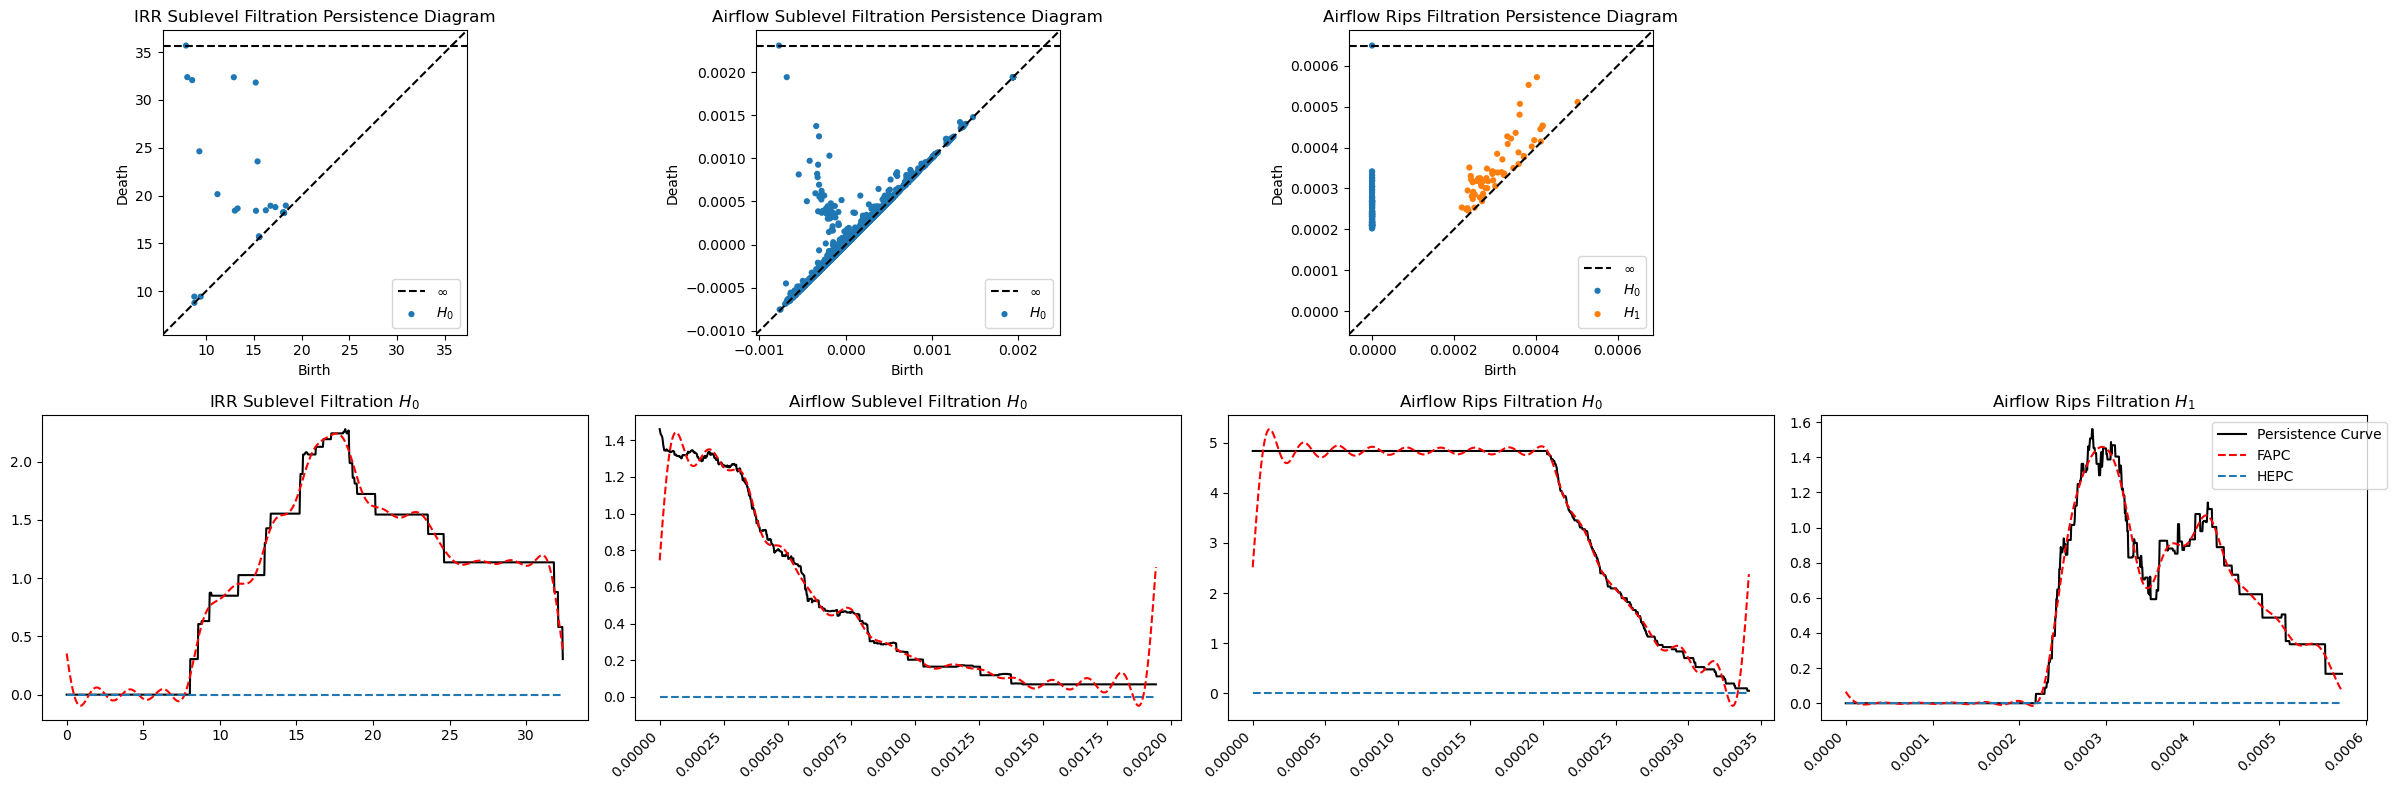

In [26]:
n_approx = 15

def get_hermite_approx(coefs, x, n):
    rv_gen = scipy.stats.norm()
    y_pred = np.zeros(n)
    for n, coef in enumerate(coefs):
        c_n = np.sqrt(2 * np.pi) / np.sqrt(np.power(2.0, n) * math.factorial(n) * np.sqrt(np.pi))
        hn = coef * c_n * scipy.special.eval_hermite(n, x) * rv_gen.pdf(x)
        y_pred += hn
    return y_pred
    # func = np.polynomial.hermite.Hermite(coefs)
    # approx = func(x)
    return approx

sublevel_irr_0_x, sublevel_irr_0_pc = loader.calculate_persistence_curve(sublevel_dgms_irr[0])
sublevel_airflow_0_x, sublevel_airflow_0_pc = loader.calculate_persistence_curve(sublevel_dgms_airflow[0])
rips_airflow_0_x, rips_airflow_0_pc = loader.calculate_persistence_curve(rips_dgms_airflow[0])
rips_airflow_1_x, rips_airflow_1_pc = loader.calculate_persistence_curve(rips_dgms_airflow[1])

fft_irr_approx = np.fft.irfft(fft_irr[:n_approx], n=sublevel_irr_0_pc.shape[0])
h_irr_approx = get_hermite_approx(hepc_irr, sublevel_irr_0_x, n=sublevel_irr_0_pc.shape[0])

fft_sub_airflow_0_approx = np.fft.irfft(fft_sub_airflow_0[:n_approx], n=sublevel_airflow_0_pc.shape[0])
h_sub_airflow_0_approx = get_hermite_approx(hepc_sub_airflow_0, sublevel_airflow_0_x, n=sublevel_airflow_0_pc.shape[0])

fft_rips_airflow_0_approx = np.fft.irfft(fft_rips_airflow_0[:n_approx], n=rips_airflow_0_pc.shape[0])
h_rips_airflow_0_approx = get_hermite_approx(hepc_rips_airflow_0, rips_airflow_0_x, n=rips_airflow_0_pc.shape[0])

fft_rips_airflow_1_approx = np.fft.irfft(fft_rips_airflow_1[:n_approx], n=rips_airflow_1_pc.shape[0])
h_rips_airflow_1_approx = get_hermite_approx(hepc_rips_airflow_1, rips_airflow_1_x, n=rips_airflow_1_pc.shape[0])

plt.close("all")
                
fig, ax = plt.subplots(2, 4, figsize=(24, 8))
persim.plot_diagrams(sublevel_dgms_irr, ax=ax[0, 0])
ax[0, 0].set_title("IRR Sublevel Filtration Persistence Diagram")
ax[1, 0].plot(sublevel_irr_0_x, sublevel_irr_0_pc, label="Persistence Curve", color="k", linestyle="-")
ax[1, 0].plot(sublevel_irr_0_x, fft_irr_approx, label="FAPC", linestyle="--", color="r")
ax[1, 0].plot(sublevel_irr_0_x, h_irr_approx, label="HEPC", linestyle="--")
ax[1, 0].set_title("IRR Sublevel Filtration $H_0$")

persim.plot_diagrams(sublevel_dgms_airflow, ax=ax[0, 1])
ax[0, 1].set_title("Airflow Sublevel Filtration Persistence Diagram")
ax[1, 1].plot(sublevel_airflow_0_x, sublevel_airflow_0_pc, label="Persistence Curve", color="k")
ax[1, 1].set_xticklabels(ax[1, 1].get_xticklabels(), rotation=45, ha="right")
ax[1, 1].plot(sublevel_airflow_0_x, fft_sub_airflow_0_approx, label="FAPC", linestyle="--", color="r")
ax[1, 1].plot(sublevel_airflow_0_x, h_sub_airflow_0_approx, label="HEPC", linestyle="--")
ax[1, 1].set_title("Airflow Sublevel Filtration $H_0$")

persim.plot_diagrams(rips_dgms_airflow, ax=ax[0, 2])
ax[0, 2].set_title("Airflow Rips Filtration Persistence Diagram")
ax[1, 2].plot(rips_airflow_0_x, rips_airflow_0_pc, label="Persistence Curve", color="k")
ax[1, 2].set_xticklabels(ax[1, 2].get_xticklabels(), rotation=45, ha="right")
ax[1, 2].plot(rips_airflow_0_x, fft_rips_airflow_0_approx, label="FAPC", linestyle="--", color="r")
ax[1, 2].plot(rips_airflow_0_x, h_rips_airflow_0_approx, label="HEPC", linestyle="--")
ax[1, 2].set_title("Airflow Rips Filtration $H_0$")

ax[0, 3].axis("off")
ax[1, 3].plot(rips_airflow_1_x, rips_airflow_1_pc, label="Persistence Curve", color="k")
ax[1, 3].set_xticklabels(ax[1, 3].get_xticklabels(), rotation=45, ha="right")
ax[1, 3].plot(rips_airflow_1_x, fft_rips_airflow_1_approx, label="FAPC", linestyle="--", color="r")
ax[1, 3].plot(rips_airflow_1_x, h_rips_airflow_1_approx, label="HEPC", linestyle="--")
ax[1, 3].set_title("Airflow Rips Filtration $H_1$")


ax[1, 3].legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.savefig("pc_approx.png", dpi=300)
plt.show()

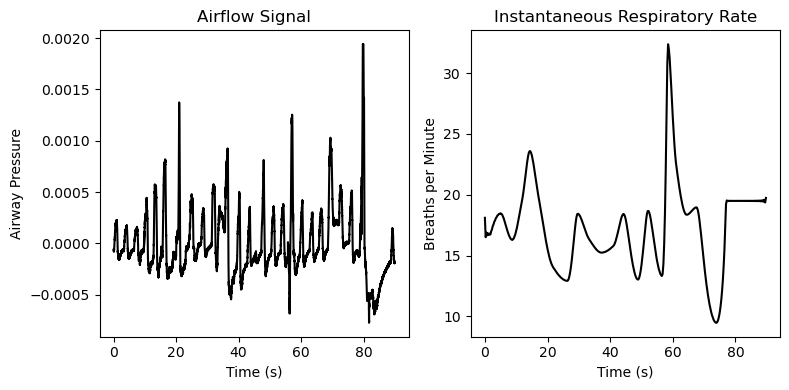

In [7]:
# Image of Instantaneous Respiratory Rate from Airflow signal
data_select = data_arr[0, :int(sfreq*90)].squeeze()
irr_signal = loader.calc_irr(data_select, sampling_freq=sfreq)
t = np.arange(data_select.shape[-1]) / sfreq
t_irr = np.arange(irr_signal.shape[-1]) / loader.target_resamp_rate

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].plot(t, data_select, color="k")
axs[0].set_title("Airflow Signal")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Airway Pressure")
axs[1].plot(t_irr, irr_signal, color="k")
axs[1].set_title("Instantaneous Respiratory Rate")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Breaths per Minute")

plt.tight_layout()
plt.savefig("irr.png", dpi=300)
plt.show()

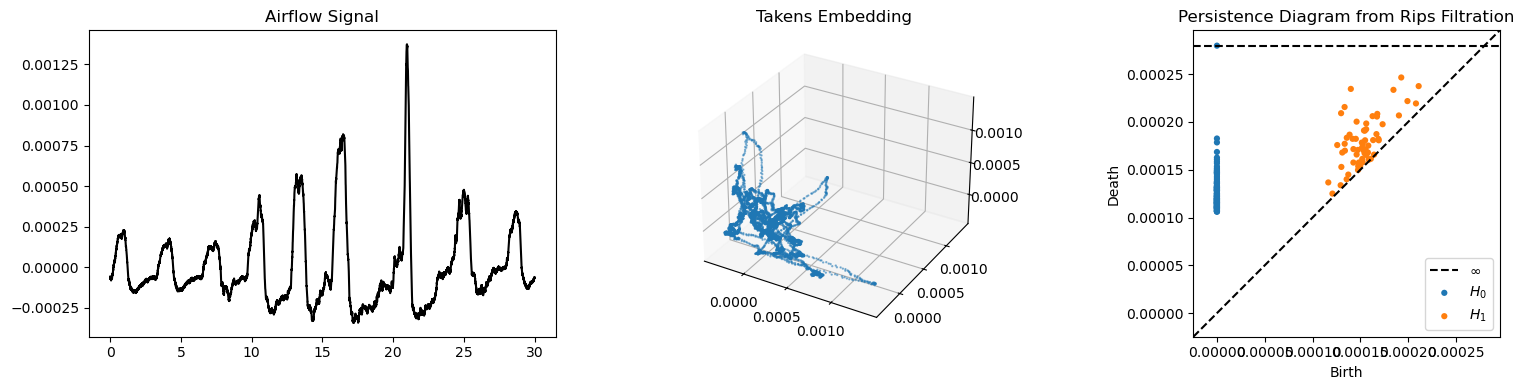

In [17]:
# Signal-Takens Embedding-PD
data_select = data_arr[0, :int(sfreq*30)].squeeze()
t = np.arange(data_select.shape[-1]) / sfreq
n_seconds = 1
tau = int(sfreq * n_seconds)

embedder = gtda.time_series.TakensEmbedding(time_delay=tau, dimension=3)
embedded_signal = embedder.fit_transform(data_select[None, :]).squeeze()
dgms = ripser(embedded_signal, n_perm=128)["dgms"]

fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132, projection="3d")
ax3 = fig.add_subplot(133)

ax1.plot(t, data_select, color="k")
ax1.set_title("Airflow Signal")

ax2.scatter(embedded_signal[:, 0], embedded_signal[:, 1], embedded_signal[:, 2], alpha=0.5, s=0.5)
ax2.set_title("Takens Embedding")

persim.plot_diagrams(dgms, ax=ax3)
ax3.set_title("Persistence Diagram from Rips Filtration")

plt.tight_layout()
plt.savefig("rips_pipeline.png", dpi=300)
plt.show()

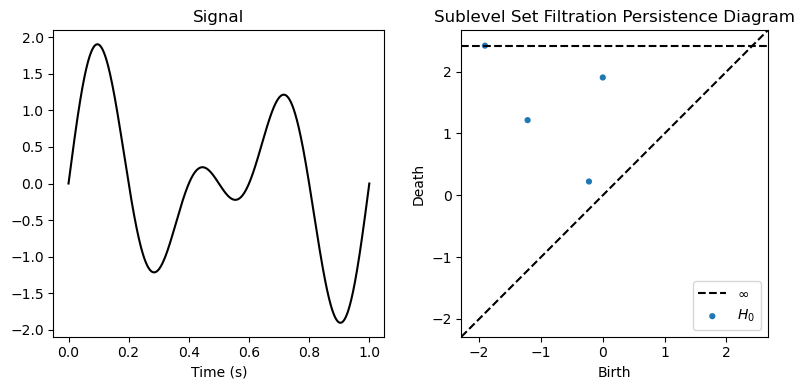

In [42]:
# Signal-Sublevel Filtration-PD

f1 = 3
f2 = 2

t = np.linspace(0, 1, 1000)
y = np.sin(2 * np.pi * t * f1) + np.sin(2 * np.pi * t * f2)

pd = cripser.computePH(y, maxdim=0)
dgm0 = pd[:, 1:3]
dgm0[-1, -1] = np.inf

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].plot(t, y, color="k")
axs[0].set_title("Signal")
axs[0].set_xlabel("Time (s)")
axs[1].set_ylabel("Amplitude")

persim.plot_diagrams(dgm0, ax=axs[1])
axs[1].set_title("Sublevel Set Filtration Persistence Diagram")

plt.tight_layout()
plt.savefig("sublevel_set_filtration.png", dpi=300)
plt.show()

In [36]:
dgm0

array([[-0.22333662,  0.22333662],
       [-1.21597575,  1.21597575],
       [ 0.        ,  1.90596041],
       [-1.90596041,         inf]])